#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project6/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

#### 2) 기본 정보 조회

In [ ]:
oil_price.info()
orders.info()
sales.info()
products.info()
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       825 non-null    datetime64[ns]
 1   WTI_Price  795 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57558 entries, 0 to 57557
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           57558 non-null  datetime64[ns]
 1   Store_ID       57558 non-null  int64         
 2   CustomerCount  57558 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934275 entries, 0 to 934274
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        934

In [ ]:
print(oil_price.isnull().sum())
print(orders.isnull().sum())
print(sales.isnull().sum())
print(products.isnull().sum())
print(stores.isnull().sum())

Date          0
WTI_Price    30
dtype: int64
Date             0
Store_ID         0
CustomerCount    0
dtype: int64
Date          0
Store_ID      0
Qty           0
Product_ID    0
dtype: int64
Product_ID      0
Product_Code    0
SubCategory     0
Category        0
LeadTime        0
Price           0
dtype: int64
Store_ID      0
City          0
State         0
Store_Type    0
dtype: int64


# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발유 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [ ]:
stores_44 = stores[stores['Store_ID'] == 44]
product_3 = products[products['Product_ID'] == 3]
sales_44_3 = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 3)]
sales_beverage = sales_44_3.groupby('Date')['Qty'].sum()

In [ ]:
stores_44 = stores[stores['Store_ID'] == 44]
product_12 = products[products['Product_ID'] == 12]
sales_44_12 = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 12)]
sales_milk = sales_44_12.groupby('Date')['Qty'].sum()

In [ ]:
stores_44 = stores[stores['Store_ID'] == 44]
product_42 = products[products['Product_ID'] == 42]
sales_44_42 = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 42)]
sales_agricultural_products = sales_44_42.groupby('Date')['Qty'].sum()

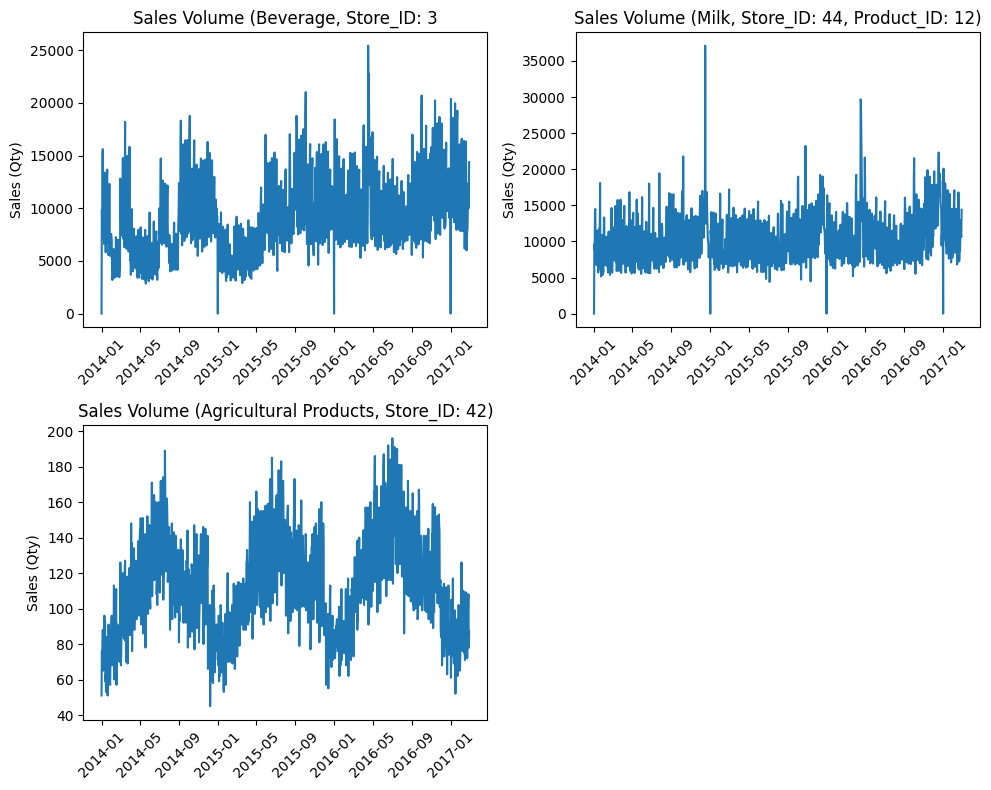

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(sales_beverage.index, sales_beverage.values)
axes[0, 0].set_title('Sales Volume (Beverage, Store_ID: 3')
axes[0, 0].set_ylabel('Sales (Qty)')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].plot(sales_milk.index, sales_milk.values)
axes[0, 1].set_title('Sales Volume (Milk, Store_ID: 44, Product_ID: 12)')
axes[0, 1].set_ylabel('Sales (Qty)')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].plot(sales_agricultural_products.index, sales_agricultural_products.values)
axes[1, 0].set_title('Sales Volume (Agricultural Products, Store_ID: 42)')
axes[1, 0].set_ylabel('Sales (Qty)')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].axis('off')  # 숨기기

plt.tight_layout()
plt.show()

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [ ]:
def plot_sales_by_subcategory(category_name, sales, products):

    # 해당 카테고리의 제품만 필터링
    product_category = products[products['Category'] == category_name]

    # 판매 데이터와 제품 데이터를 병합
    sales_category = pd.merge(sales, product_category[['Product_ID', 'Product_Code', 'SubCategory']], on='Product_ID', how='inner')

    # SubCategory별 판매량 계산
    sales_by_subcategory = sales_category.groupby('SubCategory')['Qty'].sum()
    sales_by_subcategory_time = sales_category.groupby(['Date', 'SubCategory'])['Qty'].sum().unstack()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # SubCategory별 판매량 막대그래프
    axes[0].bar(sales_by_subcategory.index, sales_by_subcategory.values, color='green', alpha=0.7)
    axes[0].set_title(f'Sales Volume by SubCategory for {category_name} Category')
    axes[0].set_xlabel('SubCategory')
    axes[0].set_ylabel('Sales Quantity')
    axes[0].tick_params(axis='x', rotation=45)

    # SubCategory별 판매량 시계열 선 그래프
    for subcategory in sales_by_subcategory_time.columns:
        axes[1].plot(sales_by_subcategory_time.index, sales_by_subcategory_time[subcategory], label=subcategory)

    axes[1].set_title(f'Time Series of Sales Volume by SubCategory for {category_name} Category')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Sales Quantity')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title='SubCategory')

    plt.tight_layout()
    plt.show()

    print(sales_by_subcategory)

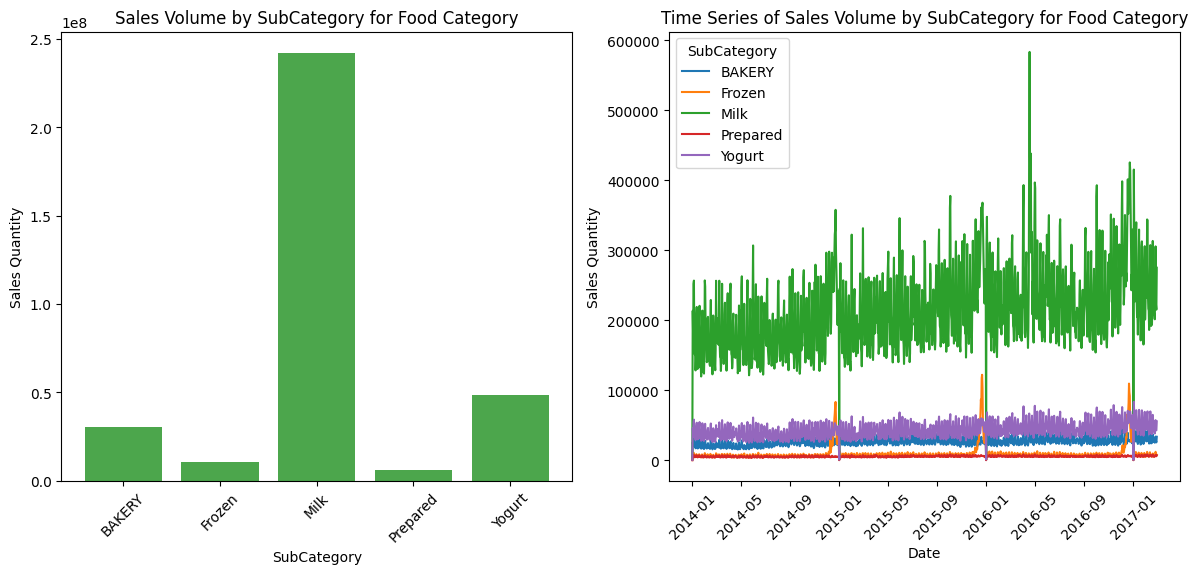

SubCategory
BAKERY      3.008853e+07
Frozen      1.036906e+07
Milk        2.421760e+08
Prepared    6.250675e+06
Yogurt      4.825008e+07
Name: Qty, dtype: float64


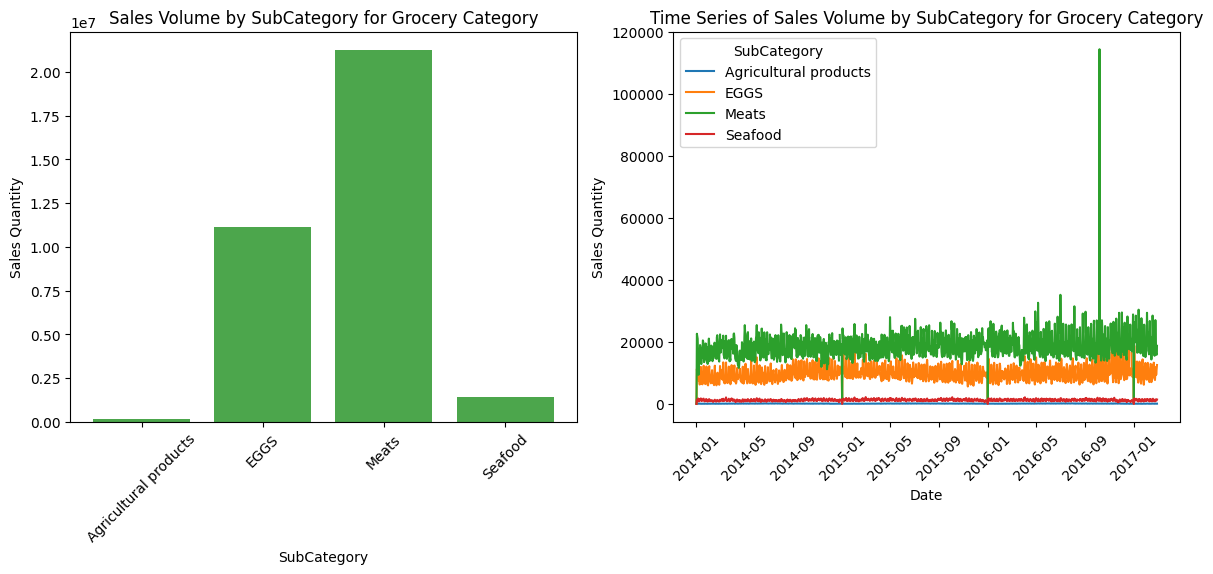

SubCategory
Agricultural products    1.304520e+05
EGGS                     1.111968e+07
Meats                    2.125028e+07
Seafood                  1.432475e+06
Name: Qty, dtype: float64


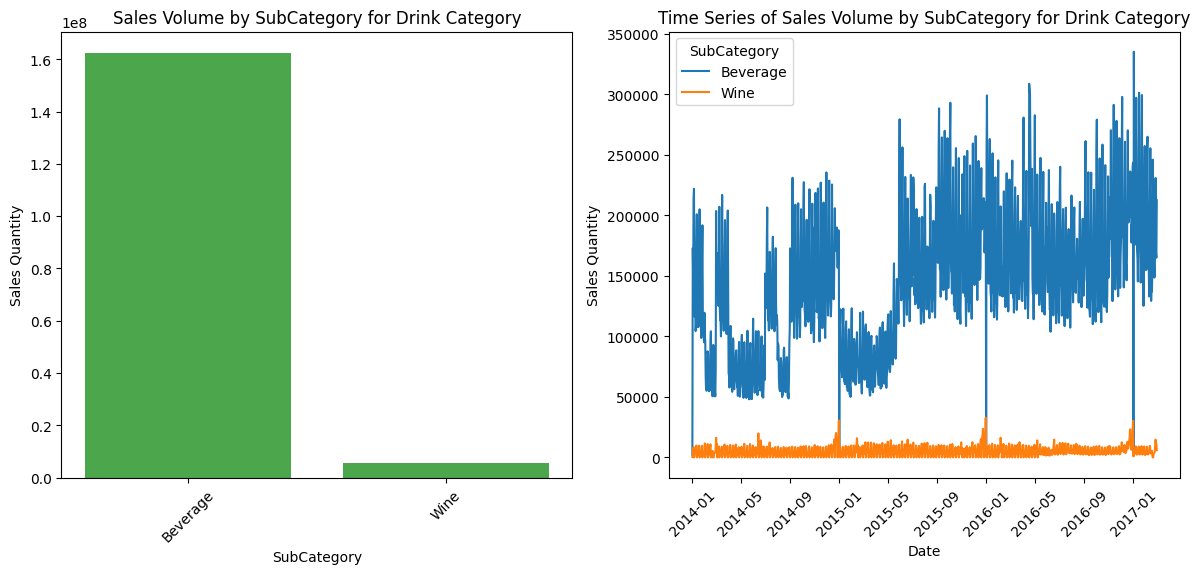

SubCategory
Beverage    162462405.0
Wine          5535059.0
Name: Qty, dtype: float64


In [ ]:
plot_sales_by_subcategory('Drink', sales, products)
plot_sales_by_subcategory('Food', sales, products)
plot_sales_by_subcategory('Grocery', sales, products)

### 3) 휘발유 가격과 상품 판매량 추이 비교

- 휘발유 가격이 낮아지면 상품 판매량도 높을 것이다. (사람들이 차를 타고 나오다가 마트를 발견하면 살 게 없어도 한 번씩 들리기 때문)
- 특히 우유 같은 상품은 미국에서 수요가 높을 것이라고 생각함

In [ ]:
def oil_trends_product(Product_ID, sdate, edate):
    display( products.loc[products['Product_ID'].isin([Product_ID])])

    temp1 = oil_price.loc[oil_price['Date'].between(sdate, edate)]
    temp2 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]

    plt.figure(figsize = (12,8))
    plt.subplot(2,1,1)
    sns.lineplot(x='Date', y = 'WTI_Price', data = temp1)
    plt.grid()

    plt.subplot(2,1,2)
    sns.lineplot(x='Date', y = 'Qty', data = temp2)
    plt.grid()
    plt.show()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
13,3,DB001,Beverage,Drink,2,8


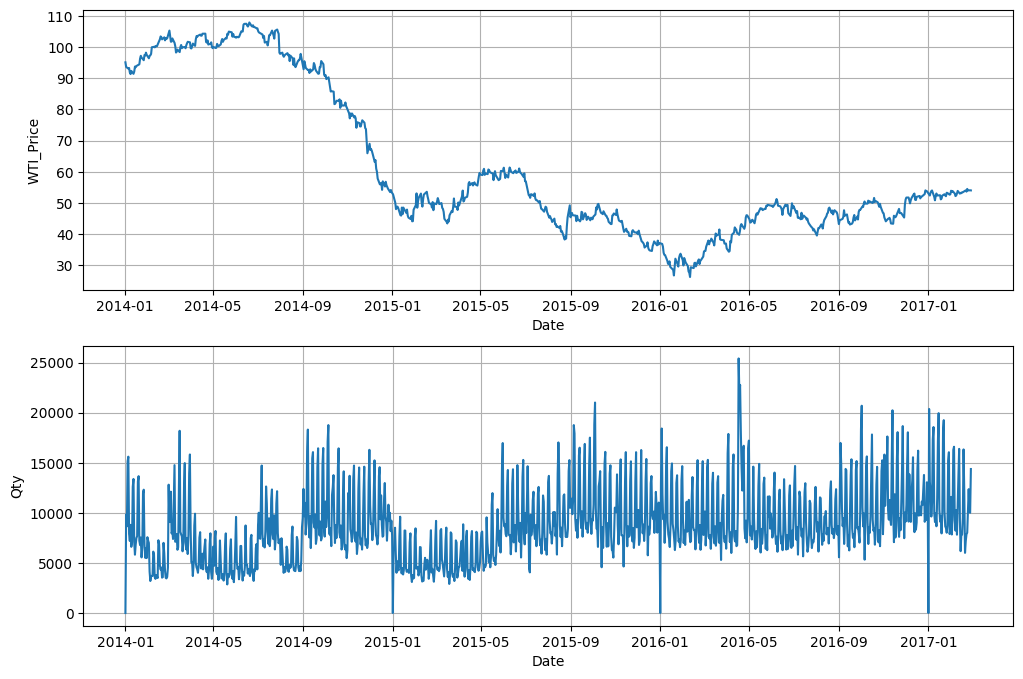

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
14,12,GA001,Milk,Food,2,6


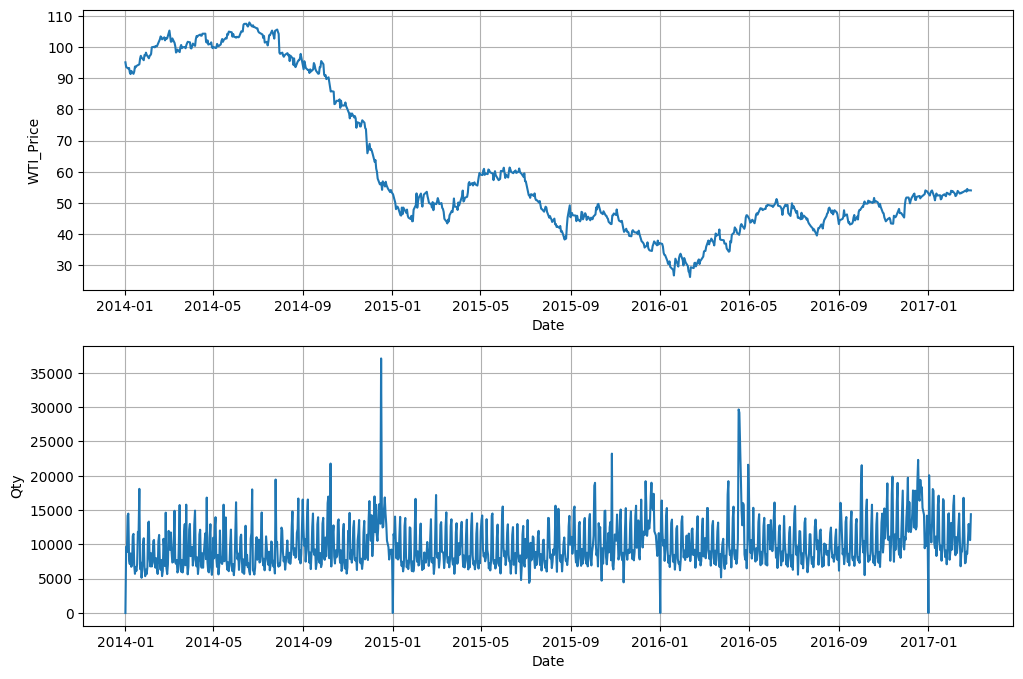

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
15,42,FM001,Agricultural products,Grocery,2,5


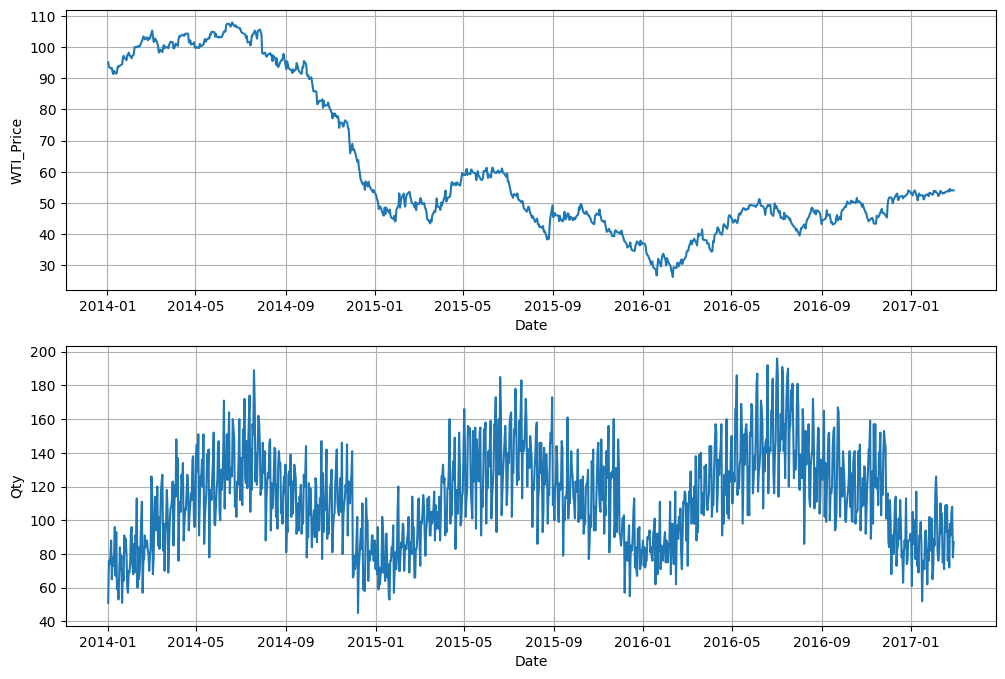

In [ ]:
oil_trends_product(3, '2014-01-01', '2017-02-28')
oil_trends_product(12, '2014-01-01', '2017-02-28')
oil_trends_product(42, '2014-01-01', '2017-02-28')

### 4) 방문 고객수와 상품 판매량 추이 비교

- 방문 고객수와 상품 판매량은 비례할 것이다.

In [ ]:
def plot_sales_and_customer_trend(sales, orders, product_id):
    # 해당 Product_ID의 판매 데이터 필터링
    sales_product = sales[sales['Product_ID'] == product_id]

    # 날짜별 판매량 합산
    sales_trend = sales_product.groupby('Date')['Qty'].sum()

    # 날짜별 고객 방문 수 합산
    customer_trend = orders.groupby('Date')['CustomerCount'].sum()

    # 판매량과 고객 방문 수 데이터 병합
    customer_sales = pd.merge(sales_trend, customer_trend, left_index=True, right_index=True)

    fig, ax1 = plt.subplots(figsize=(8, 6))

    # 상품 판매량
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Product Sales Qty')
    ax1.plot(customer_sales.index, customer_sales['Qty'], color='blue', label='Product Sales (Qty)')
    ax1.tick_params(axis='y')

    # 고객 방문 수
    ax2 = ax1.twinx()
    ax2.set_ylabel('Customer Count')
    ax2.plot(customer_sales.index, customer_sales['CustomerCount'], color='red', label='Customer Count', marker='o')
    ax2.tick_params(axis='y')

    plt.title(f'Compare Product {product_id} Sales and Customer Count Trend')
    plt.tight_layout()
    plt.show()

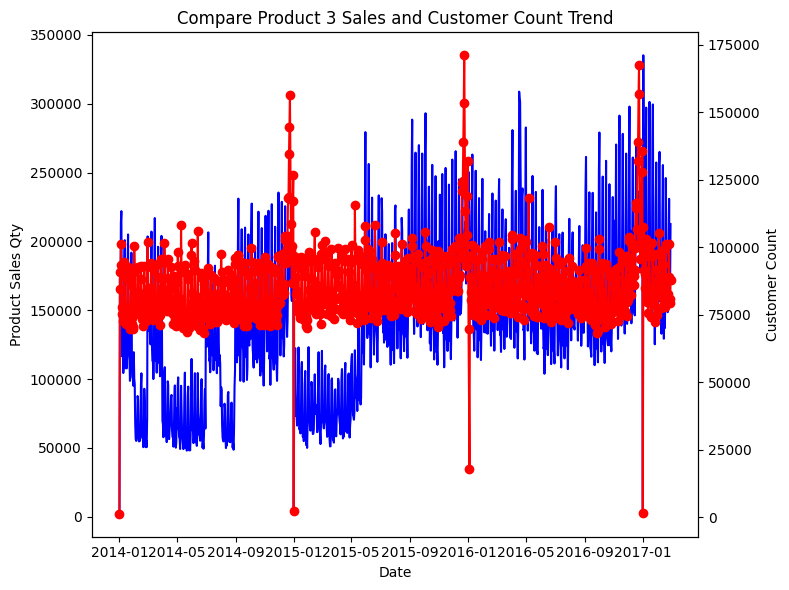

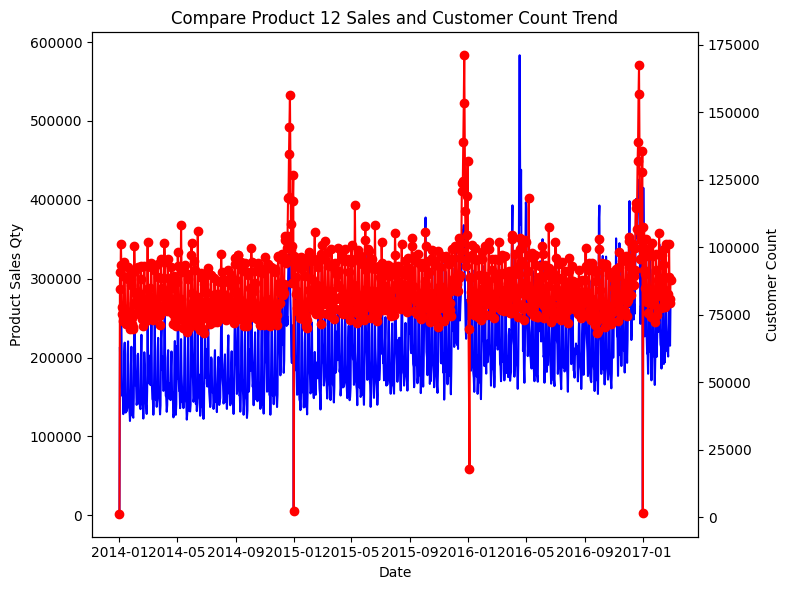

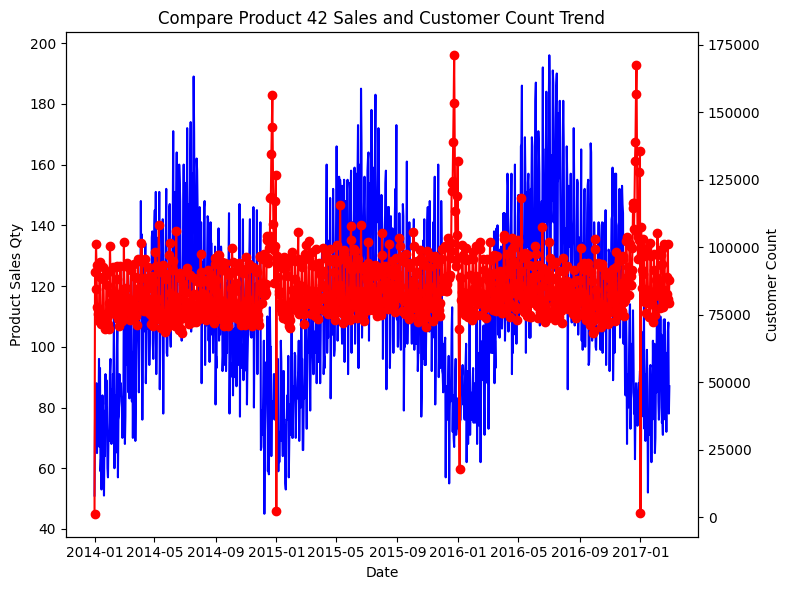

In [ ]:
plot_sales_and_customer_trend(sales, orders, 3)
plot_sales_and_customer_trend(sales, orders, 12)
plot_sales_and_customer_trend(sales, orders, 42)

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 요일별 변화량 비교

- 44번 매장에서의 우유 상품 요일별 변화량 비교

In [ ]:
def plot_daily_sales_change(sales, store_id, product_id):
    # 해당 Store_ID와 Product_ID의 판매 데이터 필터링
    sales_filtered = sales[(sales['Store_ID'] == store_id) & (sales['Product_ID'] == product_id)]

    # 요일 정보 추가
    sales_filtered['Day_of_Week'] = sales_filtered['Date'].dt.dayofweek

    # 요일별 판매량 합산
    daily_sales = sales_filtered.groupby('Day_of_Week')['Qty'].sum()

    # 일별 판매량 변화, 월요일 값도 포함하여 diff() 계산
    daily_sales_change = daily_sales.diff().fillna(0)  # NaN을 0으로 대체

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.bar(daily_sales_change.index, daily_sales_change.values)
    ax.set_xticks(daily_sales_change.index)
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    ax.set_title(f"Daily Sales Change for Product {product_id} at Store {store_id}")

    plt.tight_layout()
    plt.show()

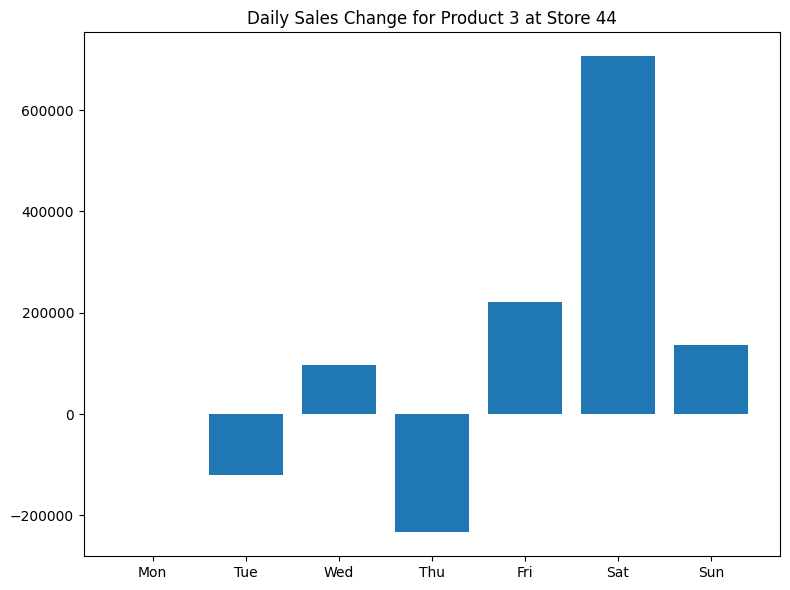

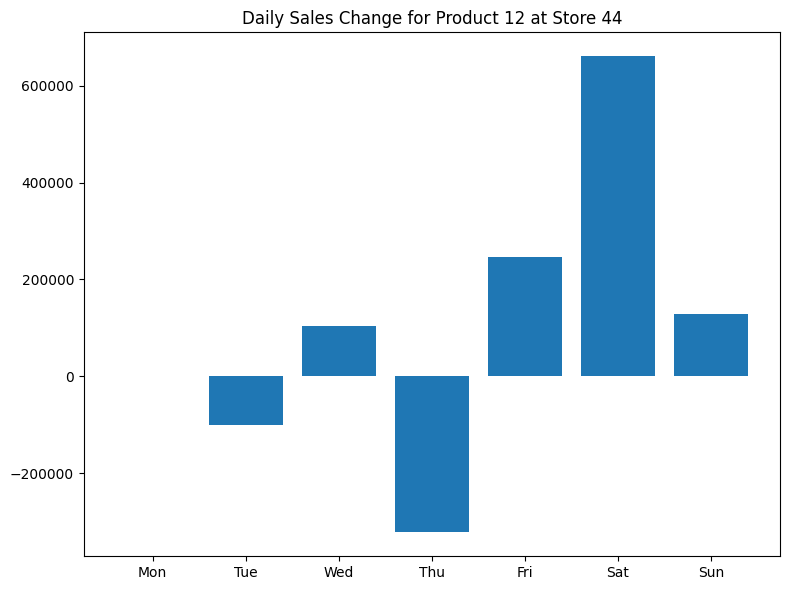

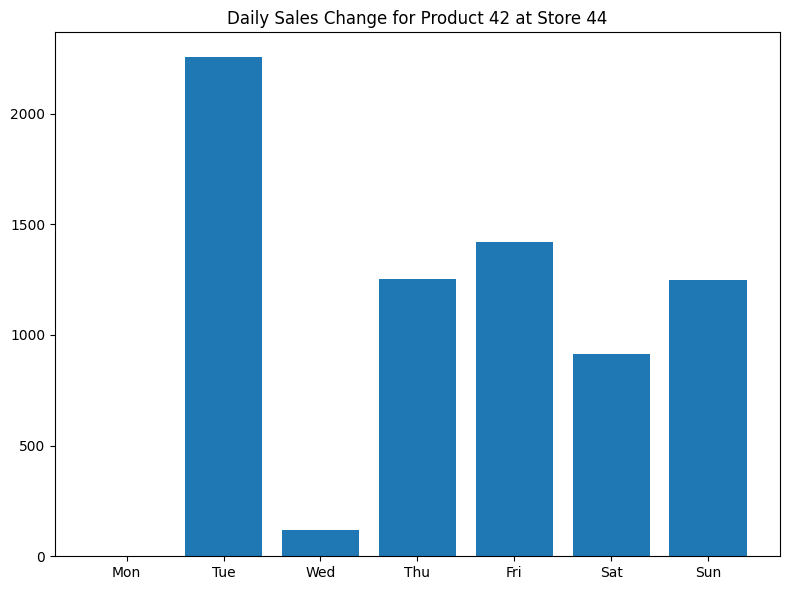

In [ ]:
plot_daily_sales_change(sales, 44, 3)
plot_daily_sales_change(sales, 44, 12)
plot_daily_sales_change(sales, 44, 42)

### 2) 추가사항
- 하루에 44번을 제외한 같은 지역의 매장의 방문수가 많다면, 44번 매장의 방문수는 적을 것이다. (+ 44번 매장의 전체 판매량도 적을 것이다.)


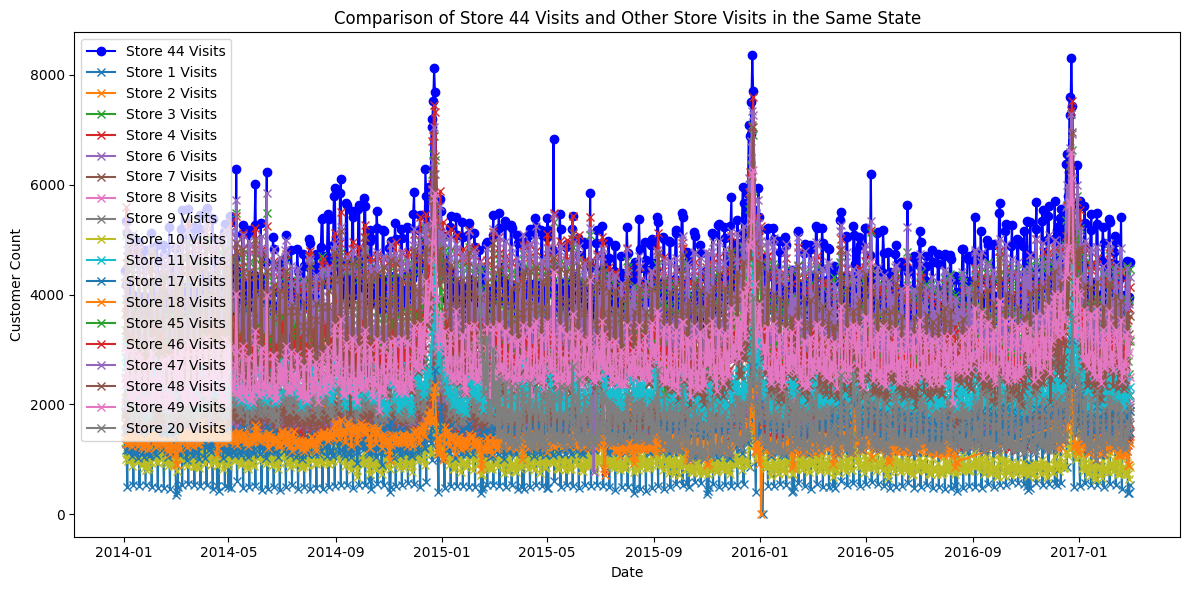

매장 44번 방문수와 같은 주에 있는 다른 매장들의 방문수 간 상관관계 비교: 0.9171090883056328


In [ ]:
# 매장 44번 방문 수 계산
store_44_visits = orders[orders['Store_ID'] == 44].groupby('Date')['CustomerCount'].sum()
store_44_state = stores[stores['Store_ID'] == 44]['State'].iloc[0]

# 같은 주(State)에 있는 다른 매장들의 방문 수 데이터
orders_with_state = pd.merge(orders, stores[['Store_ID', 'State']], on='Store_ID', how='left')
other_store_visits = orders_with_state[(orders_with_state['State'] == store_44_state) & (orders_with_state['Store_ID'] != 44)]

plt.figure(figsize=(12, 6))

# 매장 44번 방문 수 그래프
plt.plot(store_44_visits.index, store_44_visits.values, label='Store 44 Visits', color='blue', marker='o')

# 같은 주에 있는 다른 매장들의 방문 수를 매장별로 그래프에 추가
for store_id in other_store_visits['Store_ID'].unique():
    store_visits = other_store_visits[other_store_visits['Store_ID'] == store_id].groupby('Date')['CustomerCount'].sum()
    plt.plot(store_visits.index, store_visits.values, label=f'Store {store_id} Visits', marker='x')

plt.title(f"Comparison of Store 44 Visits and Other Store Visits in the Same State")
plt.xlabel('Date')
plt.ylabel('Customer Count')
plt.legend()

plt.tight_layout()
plt.show()

correlation_44_visits_other_visits = store_44_visits.corr(other_store_visits.groupby('Date')['CustomerCount'].sum())
print(f"매장 44번 방문수와 같은 주에 있는 다른 매장들의 방문수 간 상관관계 비교: {correlation_44_visits_other_visits}")

### 3) 시계열 데이터 분해

In [ ]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period) # 가법

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

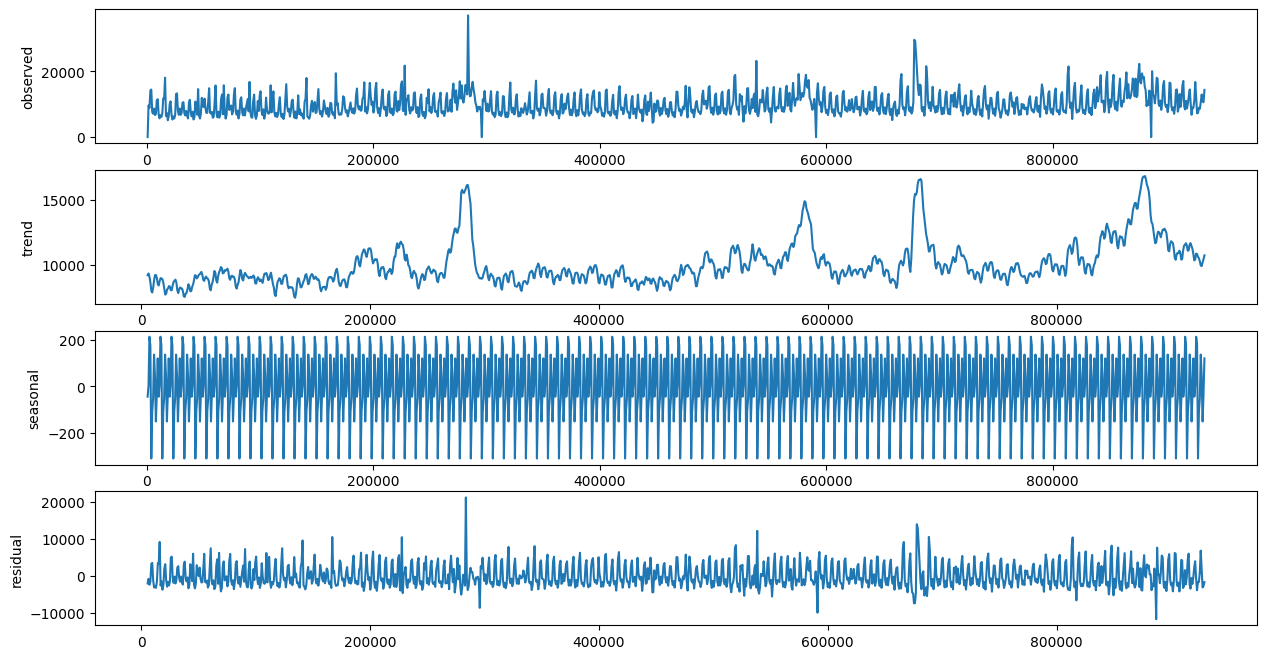

,observed,trend,seasonal,residual
651,0.0,NaN,-44.274332,NaN
1462,9647.0,NaN,4.421861,NaN
2273,8879.0,NaN,214.286370,NaN
3084,14188.0,NaN,175.622335,NaN
3895,14490.0,NaN,-310.846525,NaN
...,...,...,...,...
930871,10630.0,NaN,137.391195,NaN
931682,12978.0,NaN,44.131546,NaN
932493,10899.0,NaN,-151.191261,NaN
933304,10618.0,NaN,-32.584461,NaN


In [ ]:
decomp_plot(12, '2014-01-01', '2017-02-28', 12)

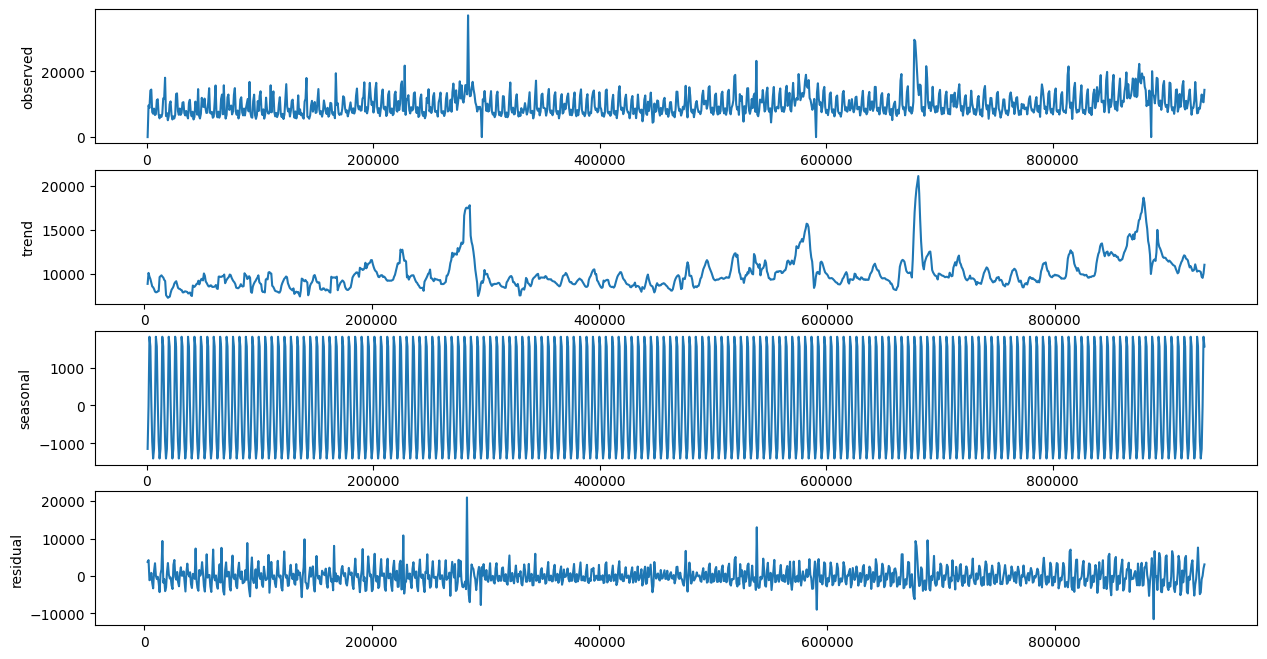

,observed,trend,seasonal,residual
651,0.0,NaN,-1146.541155,NaN
1462,9647.0,NaN,-13.491675,NaN
2273,8879.0,NaN,1813.618754,NaN
3084,14188.0,8848.857143,1556.983945,3782.158912
3895,14490.0,10089.285714,137.196726,4263.517560
...,...,...,...,...
930871,10630.0,10010.428571,-1399.585480,2019.156908
931682,12978.0,11014.142857,-1146.541155,3110.398298
932493,10899.0,NaN,-13.491675,NaN
933304,10618.0,NaN,1813.618754,NaN


In [ ]:
decomp_plot(12, '2014-01-01', '2017-02-28', 7)

### 4) 그 외 패턴 찾아보기

In [ ]:
# 44번 매장의 주요 상품 3, 12, 42 판매수량
sales_filtered = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'].isin([3, 12, 42]))]
sales_filtered['Date'] = pd.to_datetime(sales_filtered['Date'])
sales_series = sales_filtered.groupby(['Date', 'Product_ID'])['Qty'].sum().unstack().fillna(0)

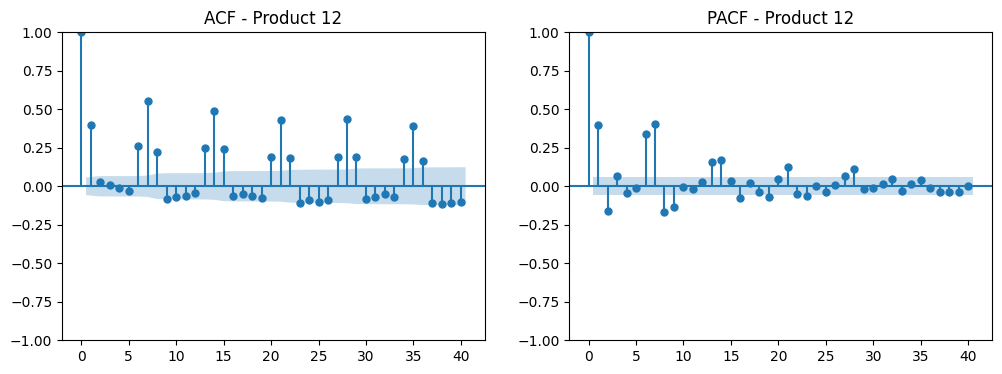

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

product_id = 12
product_series = sales_series[product_id]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# ACF 시차 40으로 지정 20 30
plot_acf(product_series, lags=40, ax=ax[0])
ax[0].set_title(f'ACF - Product {product_id}')

# PACF
plot_pacf(product_series, lags=40, ax=ax[1])
ax[1].set_title(f'PACF - Product {product_id}')

plt.show()
# 강한 자기 상관성 존재 : 비정상시계열 (acf 감소하는 추세, pacf 급격하게 감소함)

In [ ]:
from statsmodels.tsa.stattools import adfuller

# 단위근검정
result = adfuller(product_series)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f'\t{key}: {value}')

# 단위근검정 시행시 정상시계열같아보이나 자기상관함수 시행시 비정상시계열같음
# 차분시행해보기

ADF Statistic: -4.654943314839657
P-Value: 0.0001021769092589868
Critical Values:
	1%: -3.436139921033549
	5%: -2.86409660029079
	10%: -2.568131202693254


In [ ]:
product_series = sales_series[12]
product_series_diff = product_series.diff(1).dropna()
product_series_diff.head()

,12
Date,
2014-01-02,9647.0
2014-01-03,-768.0
2014-01-04,5309.0
2014-01-05,302.0
2014-01-06,-6876.0


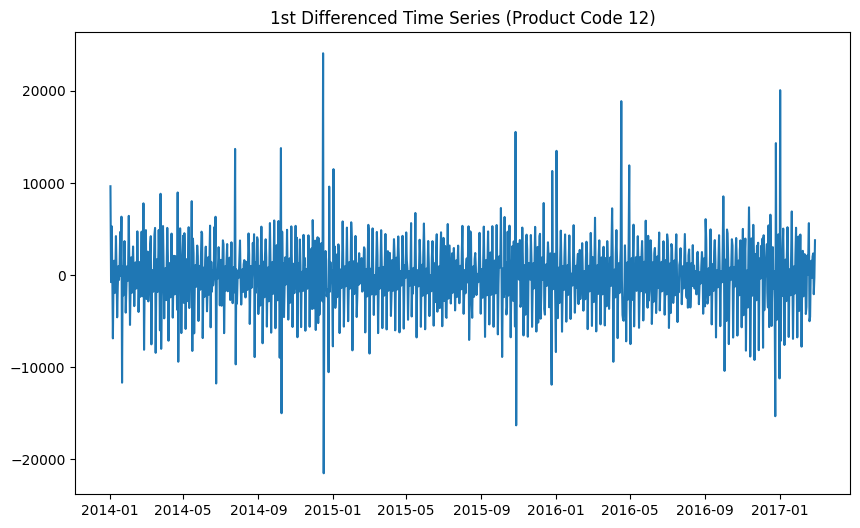

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(product_series_diff)
plt.title("1st Differenced Time Series (Product Code 12)")
plt.show()

In [ ]:
# 12개월 차분 추세 제거 실행
product_series_seasonal_diff = product_series.diff(12).dropna()

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(product_series, model='additive', period=12)
trend_removed = product_series - decomposition.trend

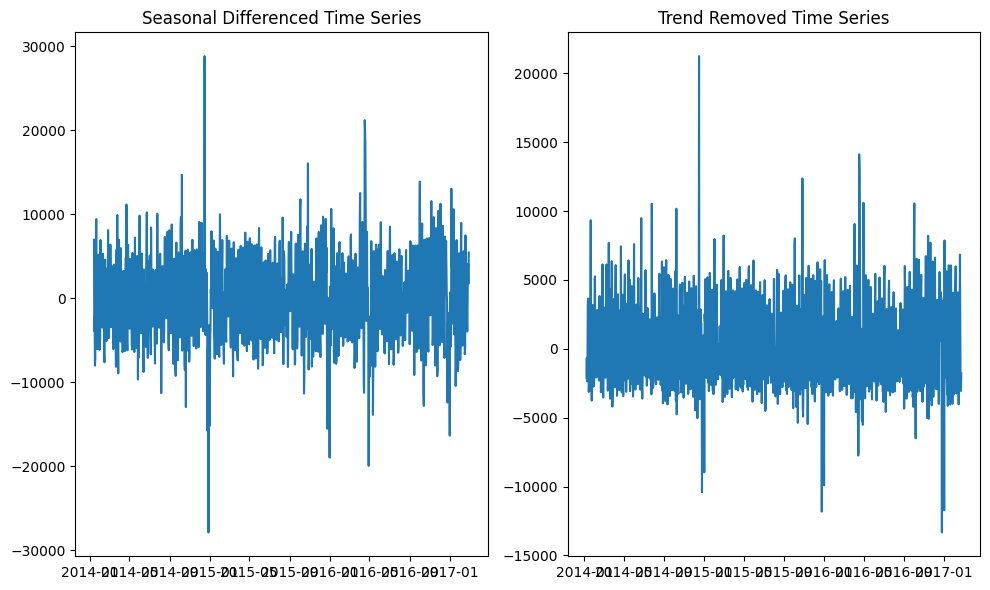

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(product_series_seasonal_diff)
plt.title('Seasonal Differenced Time Series')

plt.subplot(1, 2, 2)
plt.plot(trend_removed.dropna())
plt.title('Trend Removed Time Series')

plt.tight_layout()
plt.show()

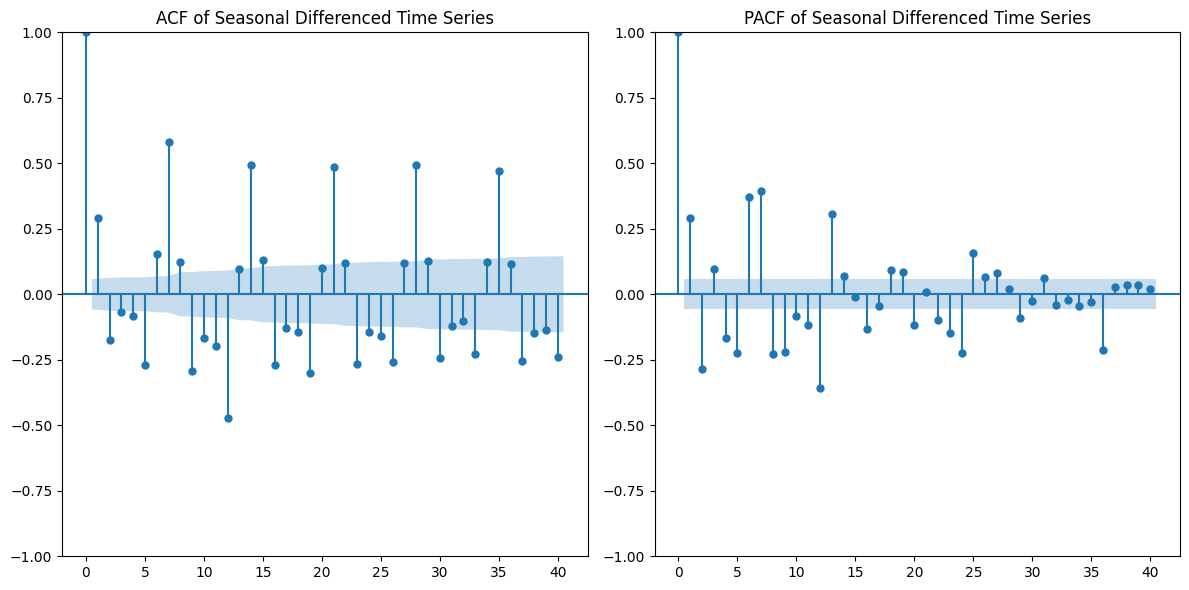

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(product_series_seasonal_diff.dropna(), lags=40, ax=ax[0])
ax[0].set_title('ACF of Seasonal Differenced Time Series')

plot_pacf(product_series_seasonal_diff.dropna(), lags=40, ax=ax[1])
ax[1].set_title('PACF of Seasonal Differenced Time Series')

plt.tight_layout()
plt.show()

- 판매량 시계열 시각화

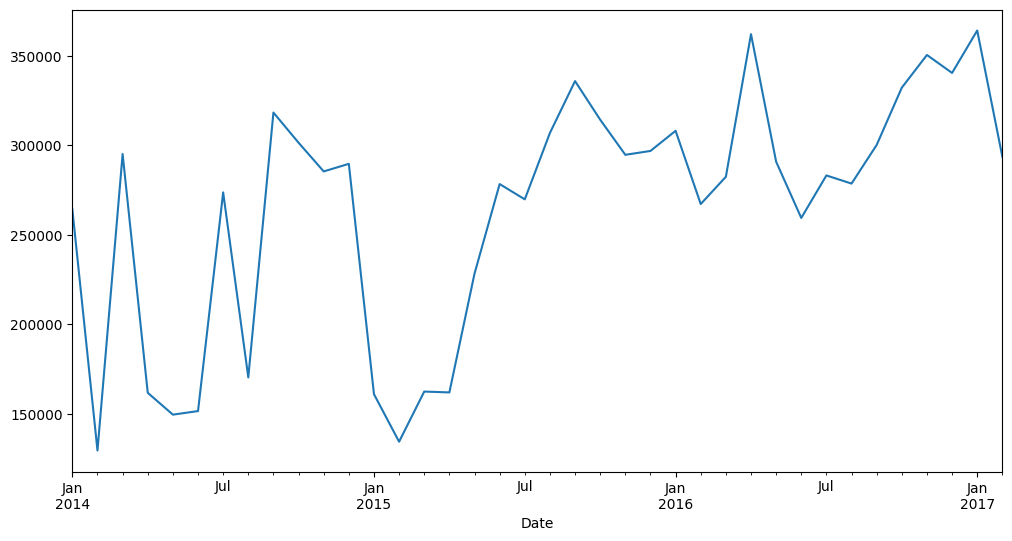

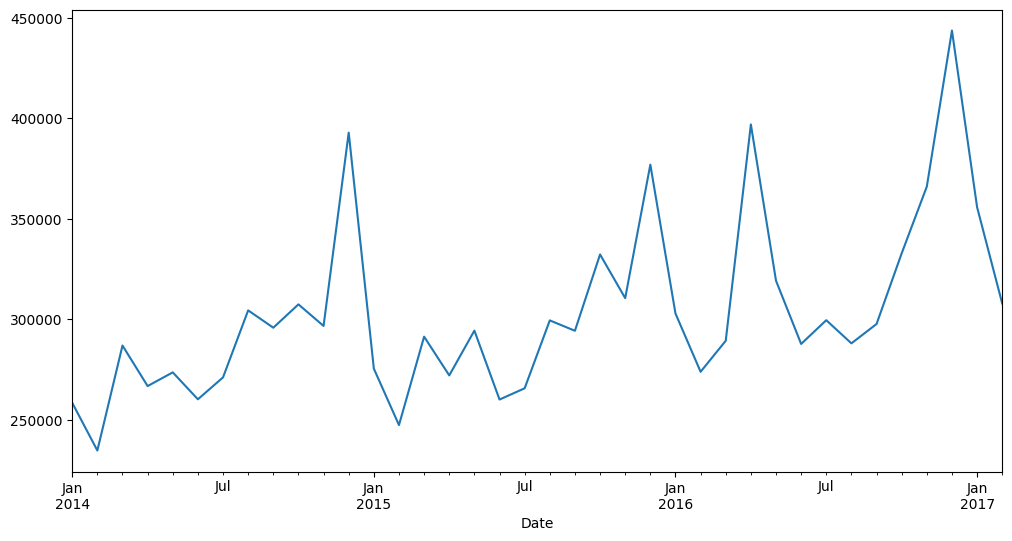

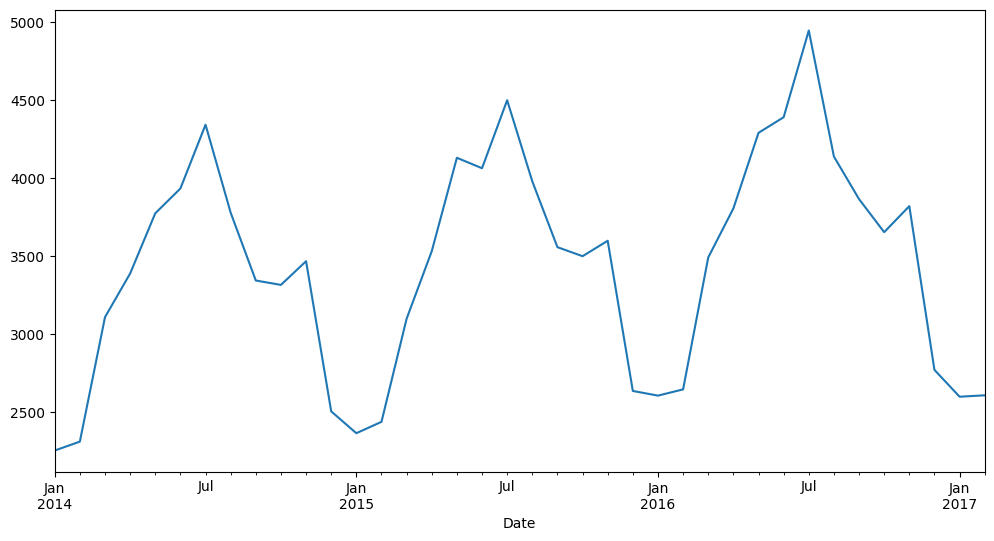

In [ ]:
sales_monthly_b = sales_44_3.resample('M', on='Date')['Qty'].sum()
sales_monthly_m = sales_44_12.resample('M', on='Date')['Qty'].sum()
sales_monthly_a = sales_44_42.resample('M', on='Date')['Qty'].sum()

plt.figure(figsize=(12, 6))
sales_monthly_b.index = sales_monthly_b.index.to_period('M')
sales_monthly_b.plot()
plt.show()

plt.figure(figsize=(12, 6))
sales_monthly_m.index = sales_monthly_m.index.to_period('M')
sales_monthly_m.plot()
plt.show()

plt.figure(figsize=(12, 6))
sales_monthly_a.index = sales_monthly_a.index.to_period('M')
sales_monthly_a.plot()
plt.show()

- 3번
  - 14년 12월~15년 2월까지의 구간에서 12월 첫째주에 판매량 커리어하이 찍고 감소
  - 16년 4월의 급격한 판매량 최고점: 4월 17, 21일

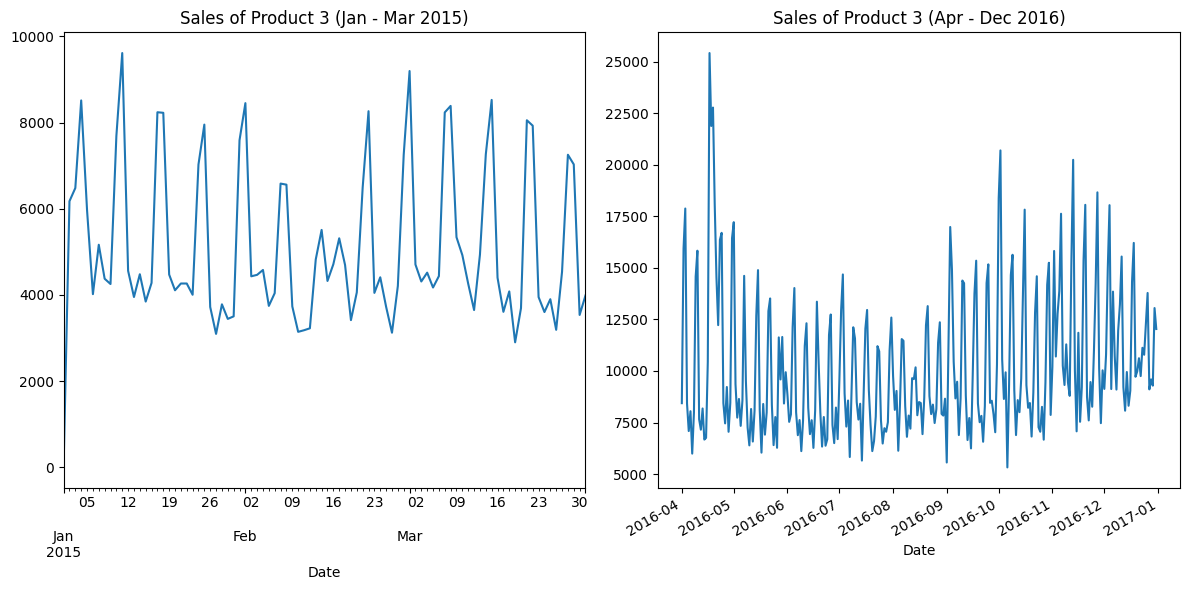

In [ ]:
# 2015년 1월~3월 데이터
sales_2015_q1 = sales_44_3 [(sales_44_3 ['Date'] >= '2015-01-01') & (sales_44_3 ['Date'] <= '2015-03-31')]

# 2016년 4월~12월 데이터
sales_2016_h2 = sales_44_3 [(sales_44_3 ['Date'] >= '2016-04-01') & (sales_44_3 ['Date'] <= '2016-12-31')]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sales_2015_q1.set_index('Date')['Qty'].plot()
plt.title('Sales of Product 3 (Jan - Mar 2015)')

plt.subplot(1, 2, 2)
sales_2016_h2.set_index('Date')['Qty'].plot()
plt.title('Sales of Product 3 (Apr - Dec 2016)')

plt.tight_layout()
plt.show()

<Axes: xlabel='Date'>

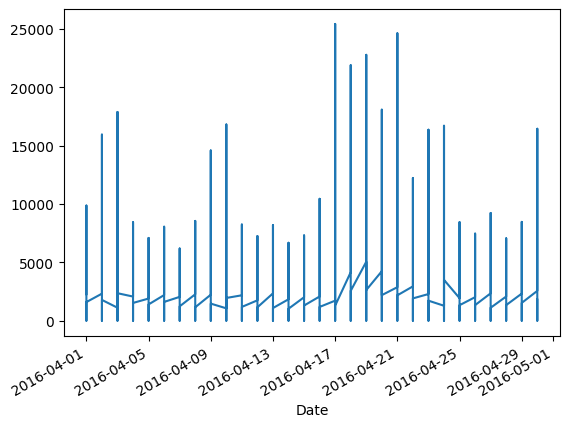

In [ ]:
# 2016년 4월 데이터
sales_april_2016 = sales[(sales['Product_ID'] == 3) & (sales['Date'] >= '2016-04-01') & (sales['Date'] <= '2016-04-30')]
sales_april_2016.set_index('Date')['Qty'].plot()

<Axes: xlabel='Date'>

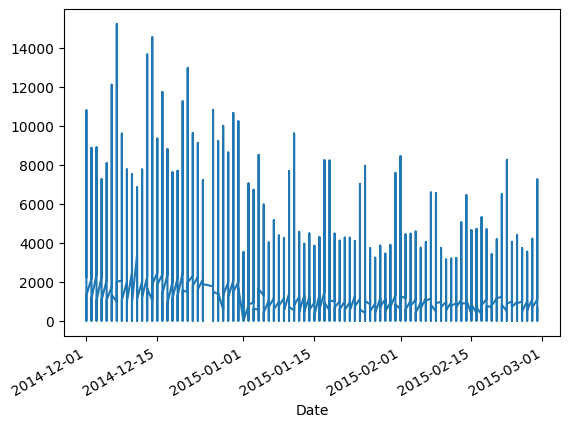

In [ ]:
sales_1412_152 = sales[(sales['Product_ID'] == 3) & (sales['Date'] >= '2014-12-01') & (sales['Date'] <= '2015-02-28')]
sales_1412_152.set_index('Date')['Qty'].plot()

- 12번
  - 계절성 요인이 크게 작용
  - 16년 3월은 연말도 아닌데 판매량이 많아서 아마 프로모션을 진행하지 않았나 싶다

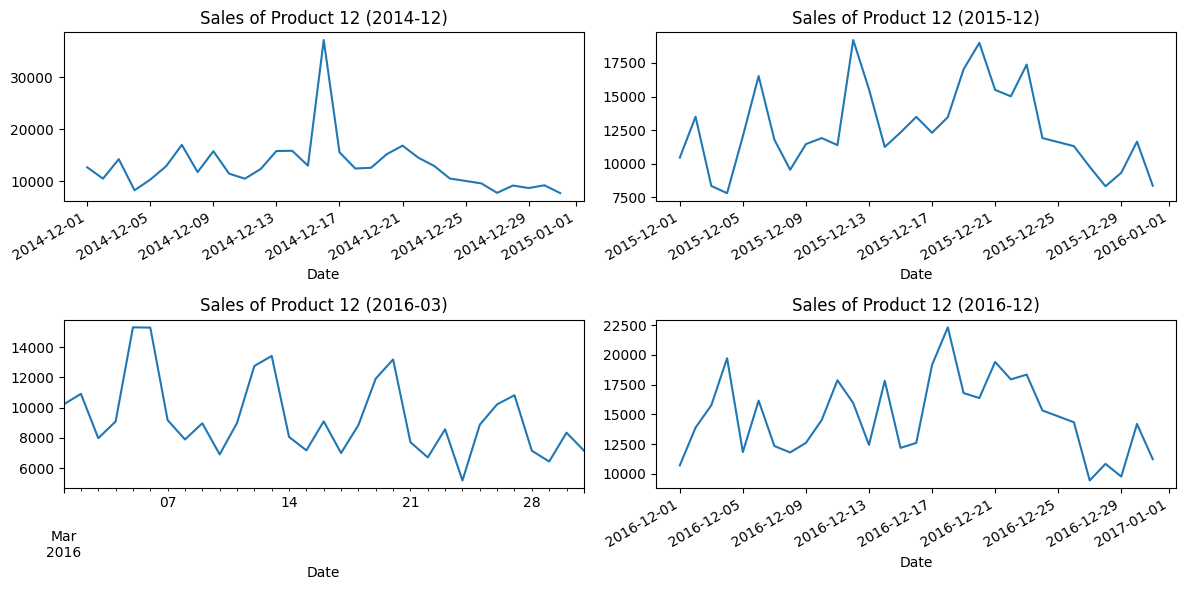

In [ ]:
# 2015년 12월 데이터
sales_2014_12 = sales_44_12[(sales_44_12['Date'] >= '2014-12-01') & (sales_44_12['Date'] <= '2014-12-31')]
sales_2015_12 = sales_44_12[(sales_44_12['Date'] >= '2015-12-01') & (sales_44_12['Date'] <= '2015-12-31')]
sales_2016_3 = sales_44_12[(sales_44_12['Date'] >= '2016-03-01') & (sales_44_12['Date'] <= '2016-03-31')]
sales_2016_12 = sales_44_12[(sales_44_12['Date'] >= '2016-12-01') & (sales_44_12['Date'] <= '2016-12-31')]

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sales_2014_12.set_index('Date')['Qty'].plot()
plt.title('Sales of Product 12 (2014-12)')

plt.subplot(2, 2, 2)
sales_2015_12.set_index('Date')['Qty'].plot()
plt.title('Sales of Product 12 (2015-12)')

plt.subplot(2, 2, 3)
sales_2016_3.set_index('Date')['Qty'].plot()
plt.title('Sales of Product 12 (2016-03)')

plt.subplot(2, 2, 4)
sales_2016_12 .set_index('Date')['Qty'].plot()
plt.title('Sales of Product 12 (2016-12)')

plt.tight_layout()
plt.show()

<Axes: xlabel='Date'>

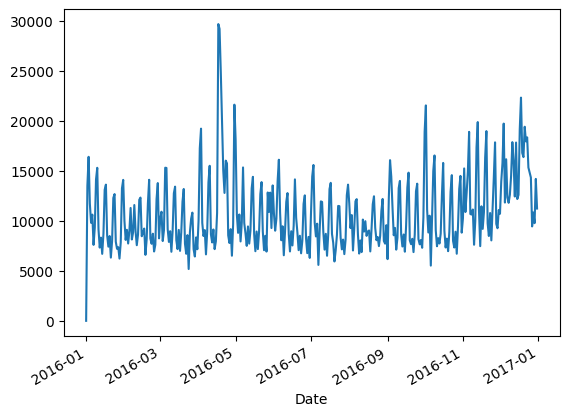

In [ ]:
sales_2016 = sales_44_12[(sales_44_12['Date'] >= '2016-01-01') & (sales_44_12['Date'] <= '2016-12-31')]
sales_2016.set_index('Date')['Qty'].plot()

- 42번

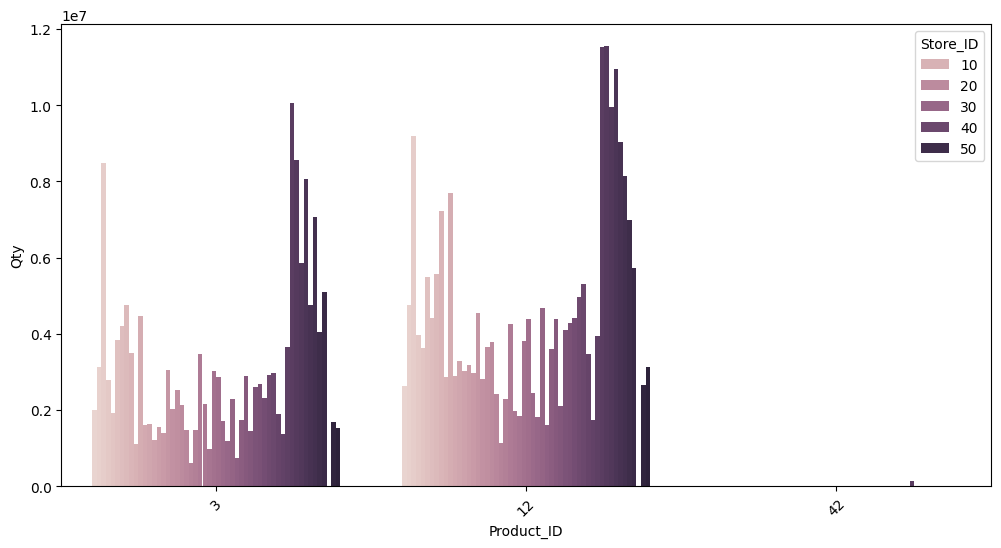

In [ ]:
# store 별로 각 상품의 판매량 계산
product_demand = sales[sales['Product_ID'].isin([3, 12, 42])].groupby(['Product_ID', 'Store_ID'])['Qty'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=product_demand, x='Product_ID', y='Qty', hue='Store_ID')
plt.show()

In [ ]:
# 42번 상품을 판매하는 매장 목록
stores_selling_42 = sales[sales['Product_ID'] == 42]['Store_ID'].unique()
stores_selling_42

array([44])

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.

### 관계 정리
- 공통점: 주말에 판매량이 확실히 높다.
- 3번과 12번은 요일에 따라 비슷한 구매패턴이 보인다
- 3번과 12번은 동일 카테고리와 비슷한 판매패턴을 보인다  

### 3번
- 시간의 흐름에 따라 판매량이 증가하는 추세
- 월 별 큰 패턴은 보이지 않음
- 2015 1 ~ 3 월까지 판매량이 저조함, 왜 저조할까
- 2016년 4월에 최고 판매량 달성 이후 하반기에 판매량이 증가함
- 14년 12월~15년 2월까지의 구간에서 12월 첫째주에 판매량 커리어하이 찍고 감소
- 16년 4월의 급격한 판매량 최고점: 4월 17, 21일

### 12번
- 주기적으로 상승과 하락을 반복
- 2014-12, 2015-12, 2016-12월에 상승: 연말, 연말파티?
- 2016-03 상승은 프로모션을 진행하지 않았나 싶음
- 2016년 이후로 전반적인 판매량 증가

### 42번
- 농산품 42만 같은 카테고리 내에서 다른 상품들보다 현저히 판매량이 적음
- 주기가 확실하게 1년 단위로 보임
- 농산품이기에 연말, 연초는 판매량이 적음: 생산(수확량)도 적을 것임
- 동일하게 여름, 가을엔 판매량 높음: 생산하는 시기
- 2016년 농사가 잘되었나 최고점을 찍음
- 수확기에 맞춰 재고를 충분히 확보하고, 리드타임에 상관없이 많이 공급하면 좋을듯하다
- 겨울철에는 재고 관리 비용을 줄이거나, 가공 및 저장 가능한 형태로 보관하여 다른 시기에도 판매할 수 있도록 방안을 찾아본다

### 지리적 특성
- 미네소타 주
  - "미국 여성이 가장 살기좋은 주는 미네소타"<美보고서> 2015-03-06
  - 전체 농작물 가치 순위에서 미국 내 5위, 농산물 수출액 순위에서는 4위를 차지
- 세인트폴
  - (옥수수랑 콩) 곡물 재배